In [1]:
!pip install openpyxl


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
pmep = pd.read_excel('MEPS 2023 Prescribed Medication.xlsx')

In [10]:
pmep_filtered = pmep[['DUPERSID', 'RXNAME', 'RXNDC', 'RXQUANTY', 'RXSF23X', 'PERWT23F', 'RXMR23X' ]]

In [13]:
pmep_filtered = pmep_filtered.rename(columns={
    'DUPERSID': 'DRUG_ID',
    'RXNAME' : 'RX_NAME',
    'RXNDC' : 'NDC',
    'RXQUANTY' : 'RX_QUANTITY',
    'RXSF23X' : 'OOP_COST',
    'PERWT23F' : 'SURVEY_WEIGHT',
    'RXMR23X' : 'MEDICARE_AMT'
})

In [16]:
consolidated_cols = [
    "DUPERSID",   # drug key
    "POVCAT23",   # income category
    "RACEV2X",    # race/ethnicity
    "AGE23X",     # age
    "SEX",        # sex
    "MCREV23",    # Medicare enrollment
    "REGION23",   #census region
    "TTLP23X"     #total income
]

consolidated_filtered = pd.read_excel(
    "MEPS 2023 Full Consolidated.xlsx",
    usecols=consolidated_cols
)

consolidated_medicare = consolidated_filtered[consolidated_filtered['MCREV23'] == 1]

In [19]:
consolidated_filtered = consolidated_filtered.rename(columns={
    "DUPERSID": "DRUG_ID",
    "POVCAT23": "INCOME_CATEGORY",
    "RACEV2X": "RACE",
    "AGE23X": "AGE",
    "SEX": "SEX",
    "MCREV23": "HAS_MEDICARE",
    "REGION23": "CENSUS_REGION",
    "TTLP23X": "TOTAL_INCOME"
})

consolidated_medicare = consolidated_medicare.rename(columns={
    "DUPERSID": "DRUG_ID",
    "POVCAT23": "INCOME_CATEGORY",
    "RACEV2X": "RACE",
    "AGE23X": "AGE",
    "SEX": "SEX",
    "MCREV23": "HAS_MEDICARE",
    "REGION23": "CENSUS_REGION",
    "TTLP23X": "TOTAL_INCOME"
})

In [22]:
merged_meps = pd.merge(
    pmep_filtered,
    consolidated_medicare,
    on='DRUG_ID',
    how='inner'
)


merged_meps_full = pd.merge(
    pmep_filtered,
    consolidated_filtered,
    on='DRUG_ID',
    how='inner'
)

In [28]:
# List of special MEPS codes to remove
invalid_codes = [-1, -2, -7, -8, -10, -15]


cols_to_check = [
    'OOP_COST',       # prescription out-of-pocket
    'AGE',            # patient age
    'INCOME_CATEGORY',# income category
    'RACE',           # race/ethnicity
    'SEX',            # sex
    'HAS_MEDICARE',   # Medicare flag
    'TOTAL_INCOME',   # total household income
    'CENSUS_REGION'   # census region
]


merged_meps = merged_meps[~merged_meps[cols_to_check].isin(invalid_codes).any(axis=1)]


In [61]:
merged_meps.isnull().sum()

DRUG_ID            0
RX_NAME            0
NDC                0
RX_QUANTITY        0
OOP_COST           0
SURVEY_WEIGHT      0
MEDICARE_AMT       0
CENSUS_REGION      0
AGE                0
SEX                0
RACE               0
TOTAL_INCOME       0
INCOME_CATEGORY    0
HAS_MEDICARE       0
dtype: int64

In [64]:
merged_meps.head()

,DRUG_ID,RX_NAME,NDC,RX_QUANTITY,OOP_COST,SURVEY_WEIGHT,MEDICARE_AMT,CENSUS_REGION,AGE,SEX,RACE,TOTAL_INCOME,INCOME_CATEGORY,HAS_MEDICARE
0,2790006101,LEVOTHYROXIN,16729044815,90.0,0.0,10328.00953,10.0,2,75,2,1,23000,4,1
1,2790006101,LEVOTHYROXIN,16729044815,90.0,0.0,10328.00953,10.0,2,75,2,1,23000,4,1
2,2790006101,LEVOTHYROXIN,16729044815,90.0,0.0,10328.00953,10.0,2,75,2,1,23000,4,1
3,2790006101,LEVOTHYROXIN,16729044815,90.0,0.0,10328.00953,10.0,2,75,2,1,23000,4,1
4,2790006101,LEVOTHYROXIN,16729044815,90.0,0.0,10328.00953,10.0,2,75,2,1,23000,4,1


In [73]:
merged_meps.columns

Index(['DRUG_ID', 'RX_NAME', 'NDC', 'RX_QUANTITY', 'OOP_COST', 'SURVEY_WEIGHT',
       'MEDICARE_AMT', 'CENSUS_REGION', 'AGE', 'SEX', 'RACE', 'TOTAL_INCOME',
       'INCOME_CATEGORY', 'HAS_MEDICARE'],
      dtype='object')

In [127]:
region_map = {
    1: "Northeast",
    2: "Midwest",
    3: "South",
    4: "West"
}

# Apply mapping
merged_meps['CENSUS_REGION'] = merged_meps['CENSUS_REGION'].map(region_map)
merged_meps_full['CENSUS_REGION'] = merged_meps_full['CENSUS_REGION'].map(region_map)

sex_map = {
    1: "Male",
    2: "Female"
}

# Apply mapping
merged_meps['SEX'] = merged_meps['SEX'].map(sex_map)

merged_meps_full['CENSUS_REGION'] = merged_meps_full['CENSUS_REGION'].map(region_map)


race_map = {
    1: "White",
    2: "Black",
    3: "American Indian/Alaska Native",
    4: "Asian Indian",
    5: "Chinese",
    6: "Filipino",
    10: "Other Asian/NH/PI",
    12: "Multiple races",
    -1: "Inapplicable"
}

# Apply mapping
merged_meps['RACE'] = merged_meps['RACE'].map(race_map)

merged_meps_full['CENSUS_REGION'] = merged_meps_full['CENSUS_REGION'].map(region_map)


income_mapping = {
    1: 'Poor',
    2: 'Near Poor',
    3: 'Low Income',
    4: 'Middle Income',
    5: 'High Income'
}

# Apply mapping to create new column with labels
merged_meps['INCOME_LABEL'] = merged_meps['INCOME_CATEGORY'].map(income_mapping)

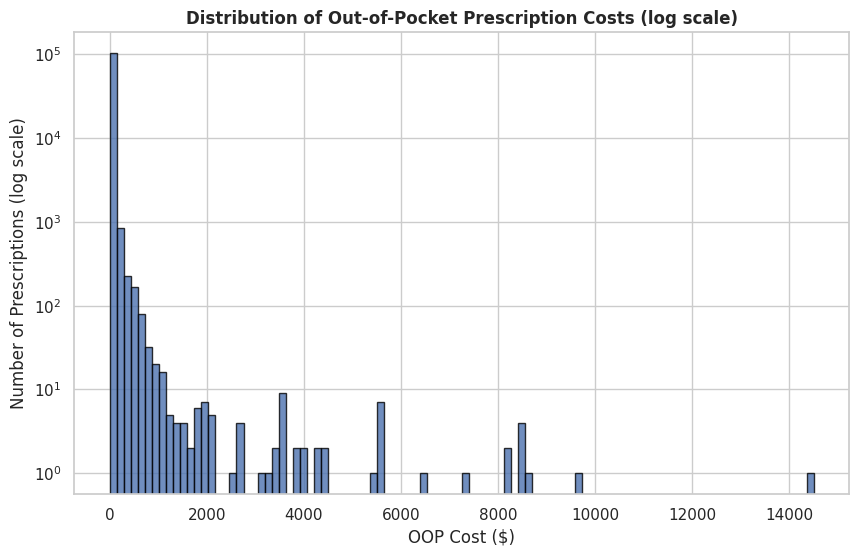

In [58]:
plt.figure(figsize=(10,6))
plt.hist(merged_meps['OOP_COST'], bins=100, edgecolor='black', alpha=0.8, log=True)
plt.title("Distribution of Out-of-Pocket Prescription Costs (log scale)", fontweight='bold')
plt.xlabel("OOP Cost ($)")
plt.ylabel("Number of Prescriptions (log scale)")
plt.show()

/tmp/ipykernel_320/4112345224.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


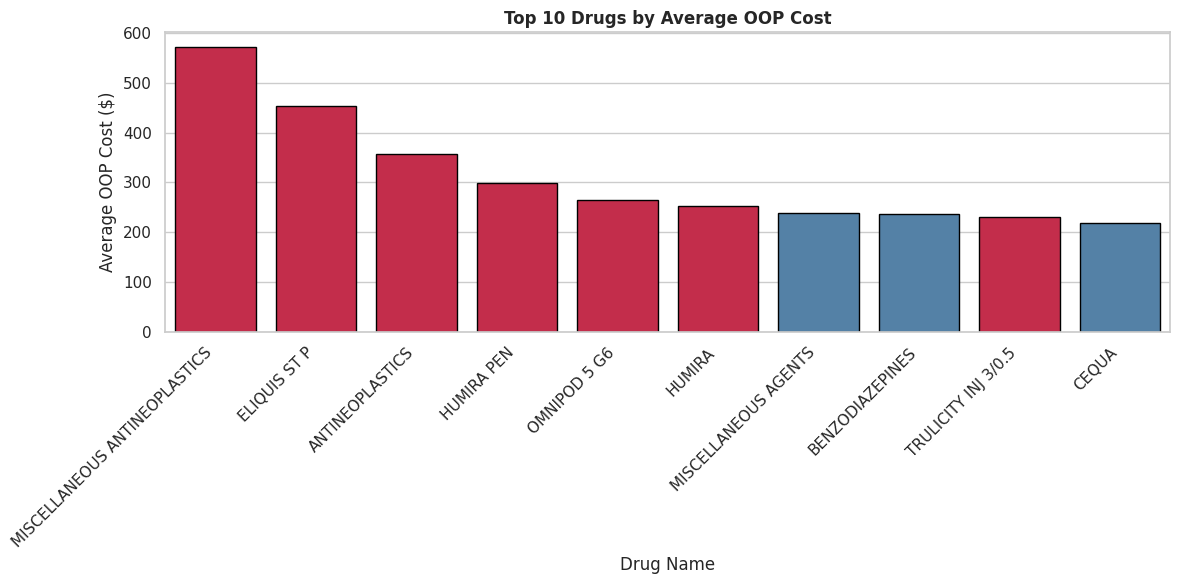

In [250]:
avg_oop_by_drug = (
    merged_meps.groupby('RX_NAME')['OOP_COST']
    .mean()
    .reset_index()
)

top10_avg_oop = avg_oop_by_drug.nlargest(10, 'OOP_COST')

specialty_drugs = [
    "MISCELLANEOUS ANTINEOPLASTICS",
    "ANTINEOPLASTICS",
    "HUMIRA PEN",
    "HUMIRA",
    "TRULICITY INJ 3/0.5",
    "OMNIPOD 5 G6",
    "ELIQUIS ST P"  
]


colors = [
    "crimson" if drug in specialty_drugs else "steelblue"
    for drug in top10_avg_oop['RX_NAME']
]

plt.figure(figsize=(12, 6))
sns.barplot(
    x='RX_NAME',
    y='OOP_COST',
    data=top10_avg_oop,
    palette=colors,
    edgecolor='black'
)

plt.title("Top 10 Drugs by Average OOP Cost", fontweight='bold')
plt.xlabel("Drug Name")
plt.ylabel("Average OOP Cost ($)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

/tmp/ipykernel_62/1083844090.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


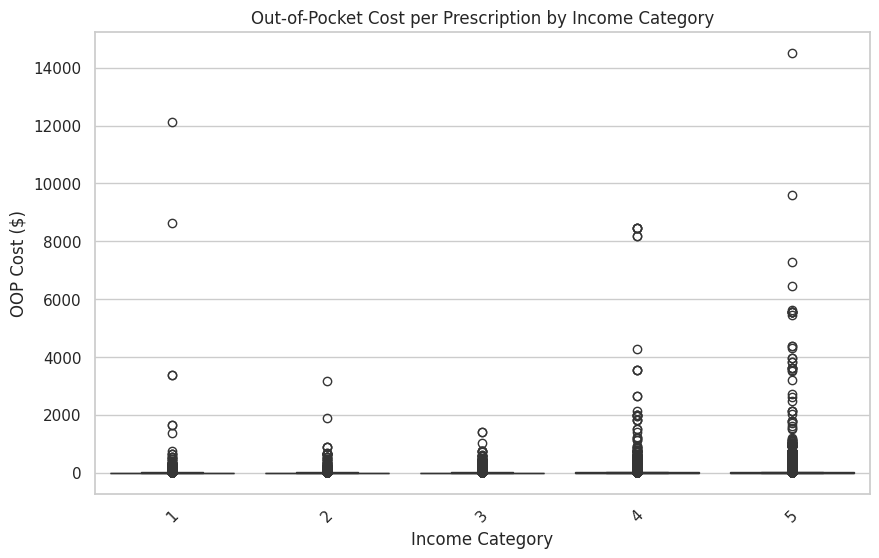

In [462]:
plt.figure(figsize=(10,6))
sns.boxplot(
    x='INCOME_CATEGORY',
    y='OOP_COST',
    data=merged_meps    
)
plt.title("Out-of-Pocket Cost per Prescription by Income Category")
plt.xlabel("Income Category")
plt.ylabel("OOP Cost ($)")
plt.xticks(rotation=45)
plt.show()

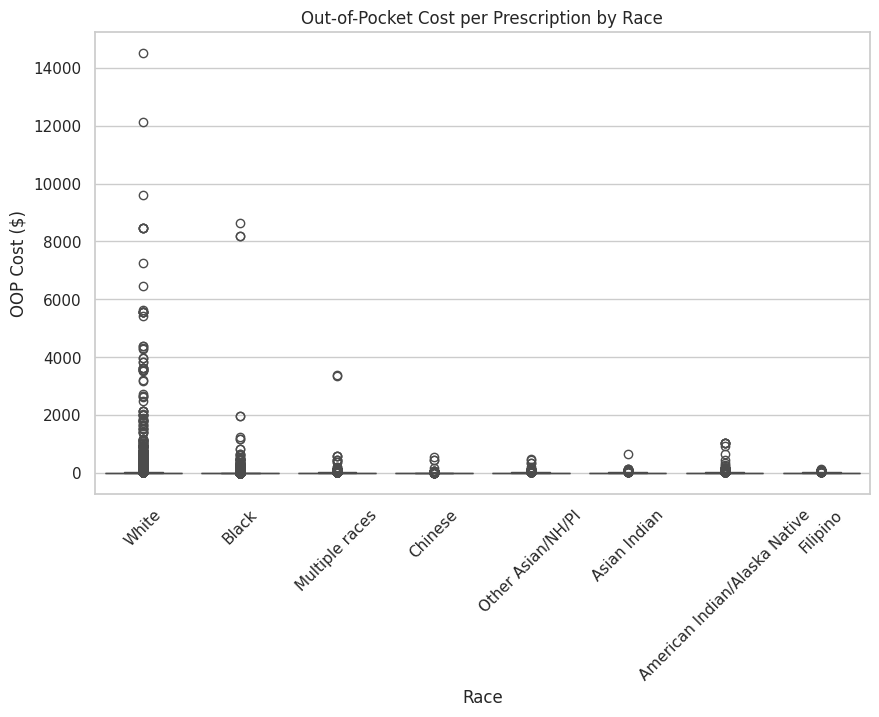

In [555]:
plt.figure(figsize=(10,6))
sns.boxplot(
    x='RACE',
    y='OOP_COST',
    data=merged_meps    
)
plt.title("Out-of-Pocket Cost per Prescription by Race")
plt.xlabel("Race")
plt.ylabel("OOP Cost ($)")
plt.xticks(rotation=45)
plt.show()

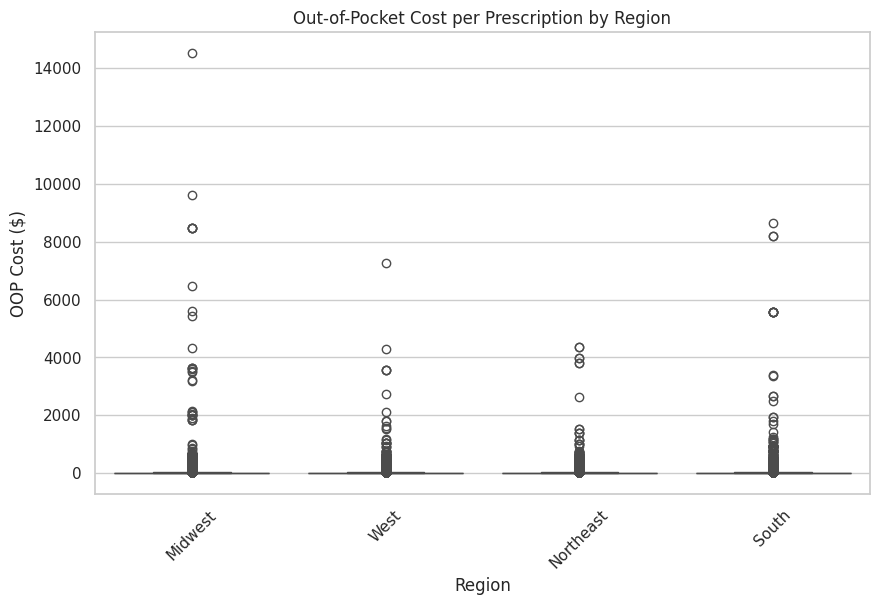

In [558]:
plt.figure(figsize=(10,6))
sns.boxplot(
    x='CENSUS_REGION',
    y='OOP_COST',
    data=merged_meps    
)
plt.title("Out-of-Pocket Cost per Prescription by Region")
plt.xlabel("Region")
plt.ylabel("OOP Cost ($)")
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_320/2501564138.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


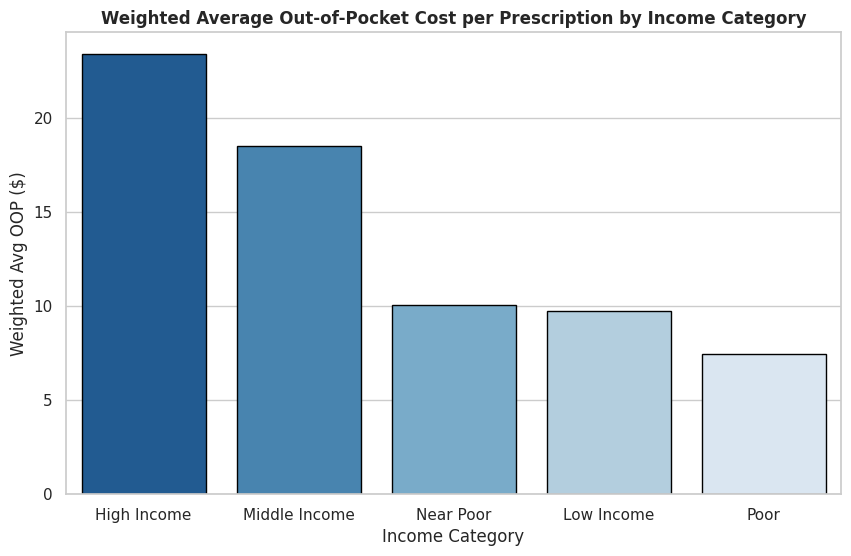

In [109]:
weighted_avg_oop_income = (
    merged_meps.groupby('INCOME_LABEL').apply(
        lambda x: (x['OOP_COST'] * x['SURVEY_WEIGHT']).sum() / x['SURVEY_WEIGHT'].sum()
    )
).reset_index(name='Weighted_Avg_OOP')


weighted_avg_oop_income = weighted_avg_oop_income.sort_values(by='Weighted_Avg_OOP', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='INCOME_LABEL',
    y='Weighted_Avg_OOP',
    data=weighted_avg_oop_income,
    palette="Blues_r",
    edgecolor="black"
)
plt.title("Weighted Average Out-of-Pocket Cost per Prescription by Income Category", fontweight='bold')
plt.xlabel("Income Category")
plt.ylabel("Weighted Avg OOP ($)")
plt.show()

/tmp/ipykernel_320/3458728.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


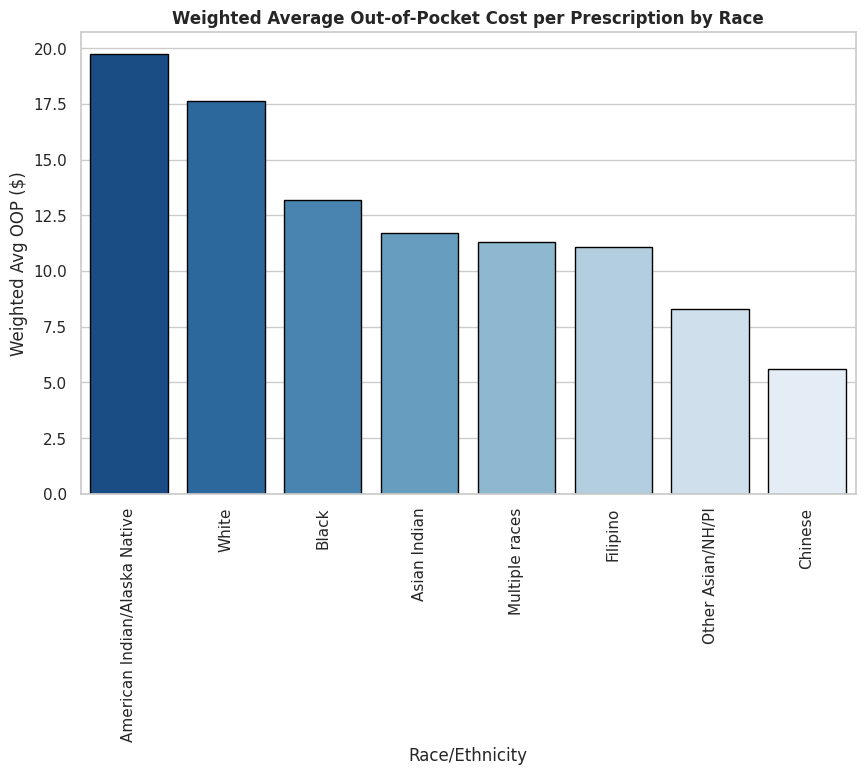

In [106]:
weighted_avg_oop_race = (
    merged_meps.groupby('RACE').apply(
        lambda x: (x['OOP_COST'] * x['SURVEY_WEIGHT']).sum() / x['SURVEY_WEIGHT'].sum()
    )
).reset_index(name='Weighted_Avg_OOP')  

weighted_avg_oop_race = weighted_avg_oop_race.sort_values(by='Weighted_Avg_OOP', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='RACE',
    y='Weighted_Avg_OOP',
    data=weighted_avg_oop_race,
    palette="Blues_r",
    edgecolor="black"
)
plt.title("Weighted Average Out-of-Pocket Cost per Prescription by Race", fontweight='bold')
plt.xlabel("Race/Ethnicity")
plt.ylabel("Weighted Avg OOP ($)")
plt.xticks(rotation=90)
plt.show()

/tmp/ipykernel_320/3949628219.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


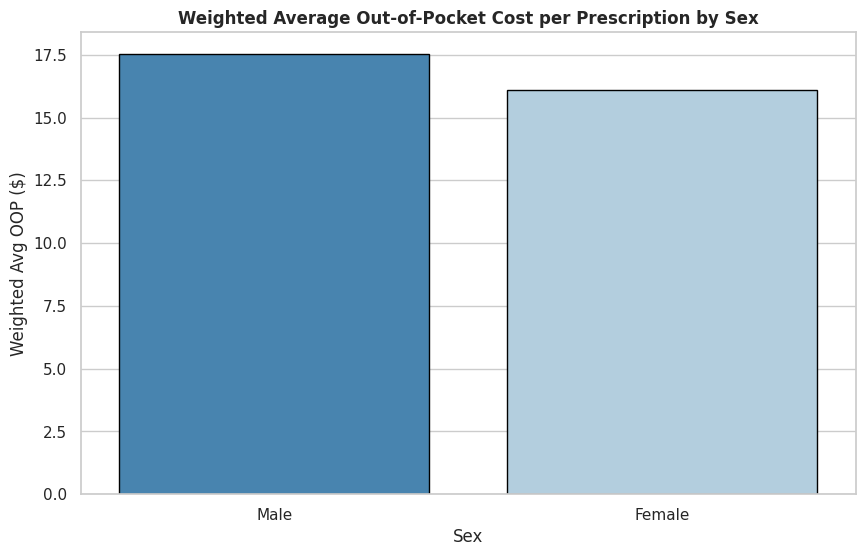

In [103]:
weighted_avg_oop_race = (
    merged_meps.groupby('SEX').apply(
        lambda x: (x['OOP_COST'] * x['SURVEY_WEIGHT']).sum() / x['SURVEY_WEIGHT'].sum()
    )
).reset_index(name='Weighted_Avg_OOP')  

weighted_avg_oop_race = weighted_avg_oop_race.sort_values(by='Weighted_Avg_OOP', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='SEX',
    y='Weighted_Avg_OOP',
    data=weighted_avg_oop_race,
    palette="Blues_r",
    edgecolor="black"
)
plt.title("Weighted Average Out-of-Pocket Cost per Prescription by Sex",fontweight='bold')
plt.xlabel("Sex")
plt.ylabel("Weighted Avg OOP ($)")
plt.show()

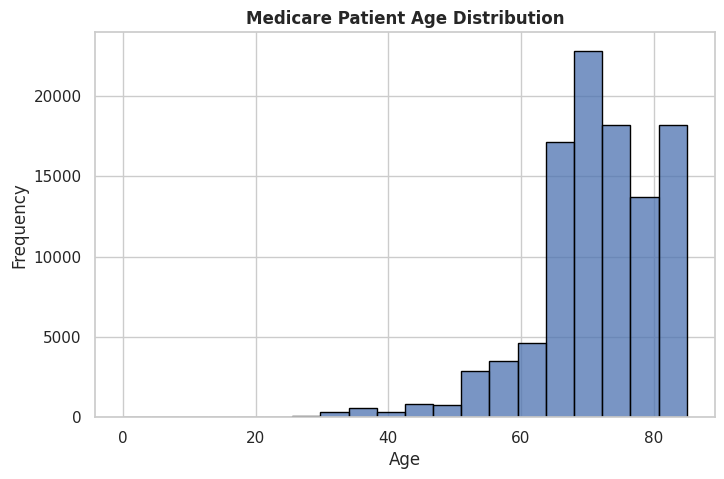

In [100]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=merged_meps,
    x='AGE',
    bins=20,
    edgecolor='black'
)

plt.title('Medicare Patient Age Distribution', fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

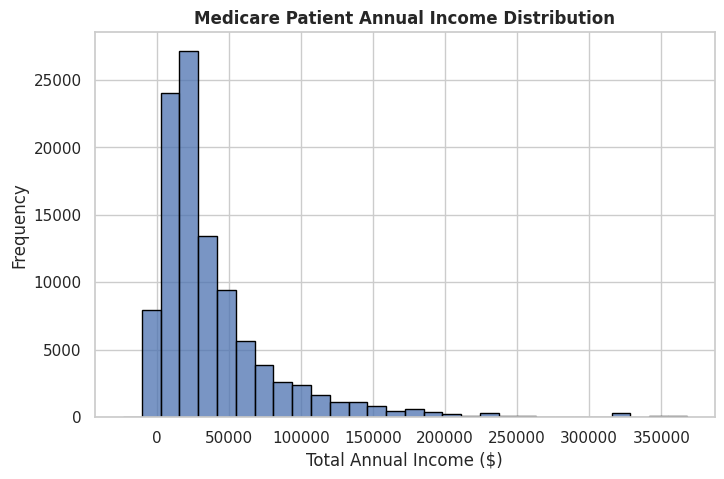

In [226]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=merged_meps,
    x='TOTAL_INCOME',
    bins=30,
    edgecolor='black'
)

plt.title('Medicare Patient Annual Income Distribution', fontweight='bold')
plt.xlabel('Total Annual Income ($)')
plt.ylabel('Frequency')
plt.show()

In [79]:
bins = [0, 64, 74, 84, 120]  
labels = ['<65', '65–74', '75–84', '85+']

# Create new column
merged_meps['AGE_GROUP'] = pd.cut(merged_meps['AGE'], bins=bins, labels=labels, right=True)

/tmp/ipykernel_320/1140956433.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_meps.groupby('AGE_GROUP').apply(
/tmp/ipykernel_320/1140956433.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


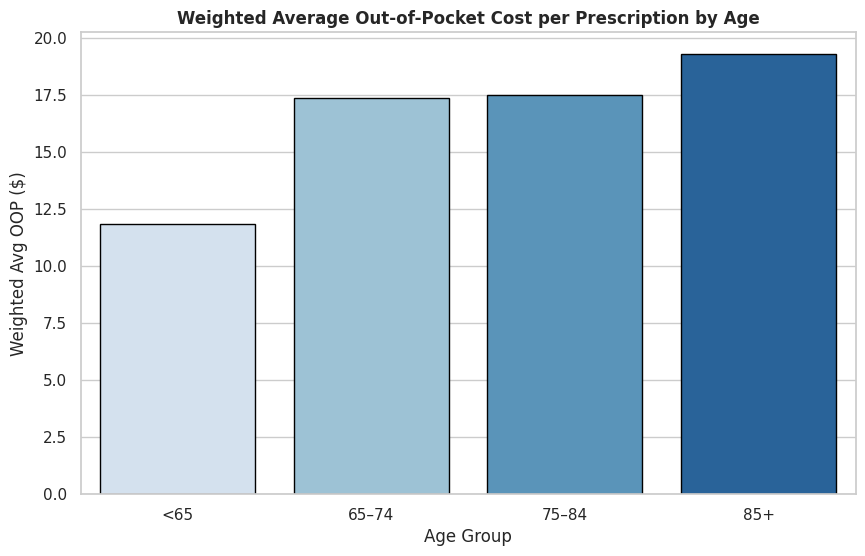

In [202]:
weighted_avg_oop_race = (
    merged_meps.groupby('AGE_GROUP').apply(
        lambda x: (x['OOP_COST'] * x['SURVEY_WEIGHT']).sum() / x['SURVEY_WEIGHT'].sum()
    )
).reset_index(name='Weighted_Avg_OOP')  

weighted_avg_oop_race = weighted_avg_oop_race.sort_values(by='Weighted_Avg_OOP', ascending=False)


plt.figure(figsize=(10,6))
sns.barplot(
    x='AGE_GROUP',
    y='Weighted_Avg_OOP',
    data=weighted_avg_oop_race,
    palette="Blues",
    edgecolor='black'
)
plt.title("Weighted Average Out-of-Pocket Cost per Prescription by Age", fontweight='bold')
plt.xlabel("Age Group")
plt.ylabel("Weighted Avg OOP ($)")
plt.show()

/tmp/ipykernel_320/2743751537.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


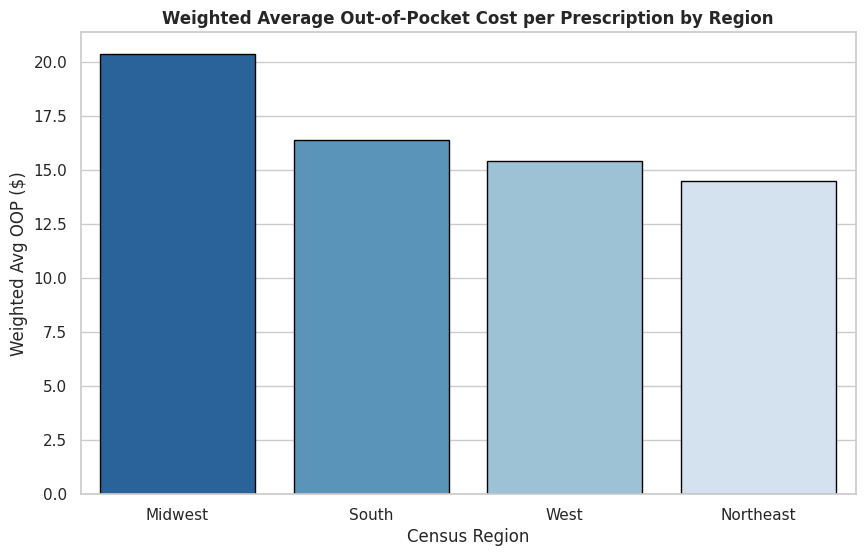

In [121]:
weighted_avg_oop_region = (
    merged_meps.groupby('CENSUS_REGION').apply(
        lambda x: (x['OOP_COST'] * x['SURVEY_WEIGHT']).sum() / x['SURVEY_WEIGHT'].sum()
    )
).reset_index(name='Weighted_Avg_OOP')  

weighted_avg_oop_region = weighted_avg_oop_region.sort_values(by='Weighted_Avg_OOP', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='CENSUS_REGION',
    y='Weighted_Avg_OOP',
    data=weighted_avg_oop_region,
    palette="Blues_r",
    edgecolor='black'
)
plt.title("Weighted Average Out-of-Pocket Cost per Prescription by Region", fontweight='bold')
plt.xlabel("Census Region")
plt.ylabel("Weighted Avg OOP ($)")
plt.show()

In [307]:
top_drugs = (
    merged_meps.groupby('RX_NAME')[['OOP_COST', 'MEDICARE_AMT']]
    .sum()
    .sort_values(by='OOP_COST', ascending=False)
    .head(10)
)

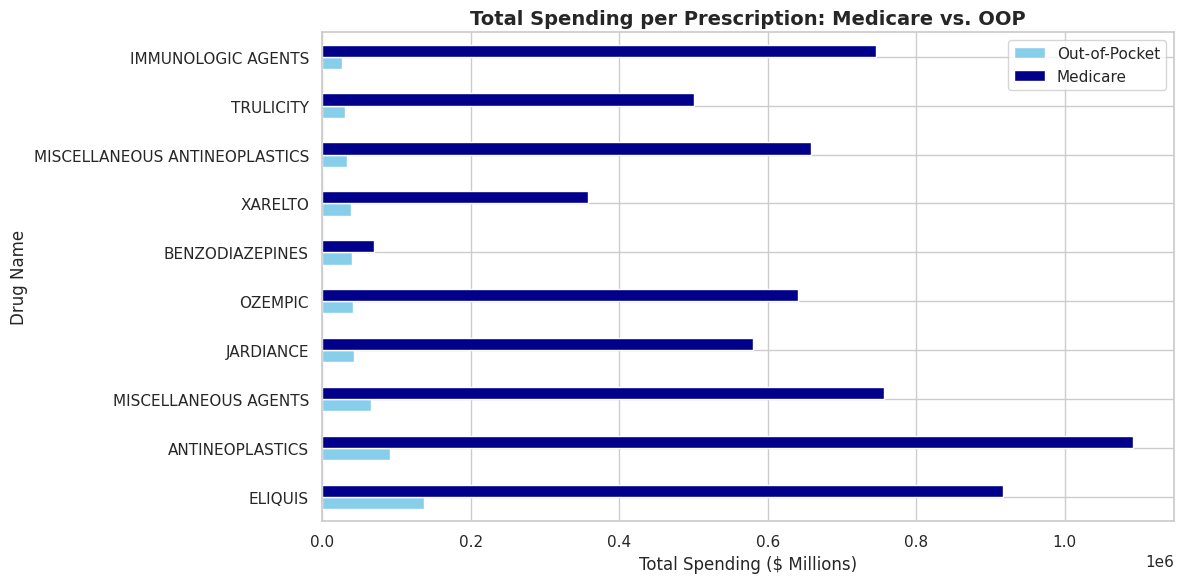

In [310]:
ax = top_drugs.plot(
    kind='barh',
    stacked=False,
    figsize=(12,6),
    color=['skyblue', 'darkblue'] 
)

plt.title("Total Spending per Prescription: Medicare vs. OOP", fontsize=14, fontweight='bold')
plt.xlabel("Total Spending ($ Millions)")
plt.ylabel("Drug Name")
plt.legend(["Out-of-Pocket", "Medicare"])
plt.tight_layout()
plt.show()

In [130]:
top10_drugs = (
    merged_meps.groupby('RX_NAME')
    .size()  
    .nlargest(10)
    .index
)

In [184]:
top10_drugs_list = top10_drugs.tolist()  # from your previous code
top_drugs_df = merged_meps[merged_meps['RX_NAME'].isin(top10_drugs_list)]


avg_oop_per_patient = (
    top_drugs_df.groupby(['RX_NAME', 'RACE'])['OOP_COST']
    .agg(['mean', 'median', 'count'])
    .reset_index()
    .rename(columns={'mean': 'Avg_OOP', 'median': 'Median_OOP', 'count': 'Num_Patients'})
)

MIN_PATIENTS = 20
avg_oop_per_patient = avg_oop_per_patient[avg_oop_per_patient['Num_Patients'] >= MIN_PATIENTS]

avg_oop_per_patient = avg_oop_per_patient.sort_values(by='Avg_OOP', ascending=False)
avg_oop_per_patient.head(20)

,RX_NAME,RACE,Avg_OOP,Median_OOP,Num_Patients
22,GABAPENTIN,Other Asian/NH/PI,17.12,2.00,21
12,ATORVASTATIN,Filipino,15.37,1.45,43
63,OMEPRAZOLE,American Indian/Alaska Native,11.95,2.48,27
16,GABAPENTIN,American Indian/Alaska Native,11.87,10.13,28
8,ATORVASTATIN,American Indian/Alaska Native,11.15,3.50,54
47,METFORMIN,American Indian/Alaska Native,9.55,4.15,85
25,LEVOTHYROXIN,Asian Indian,9.03,9.52,20
61,METOPROL SUC,Other Asian/NH/PI,8.21,2.48,28
62,METOPROL SUC,White,7.57,4.15,1532
65,OMEPRAZOLE,Black,7.25,1.45,233


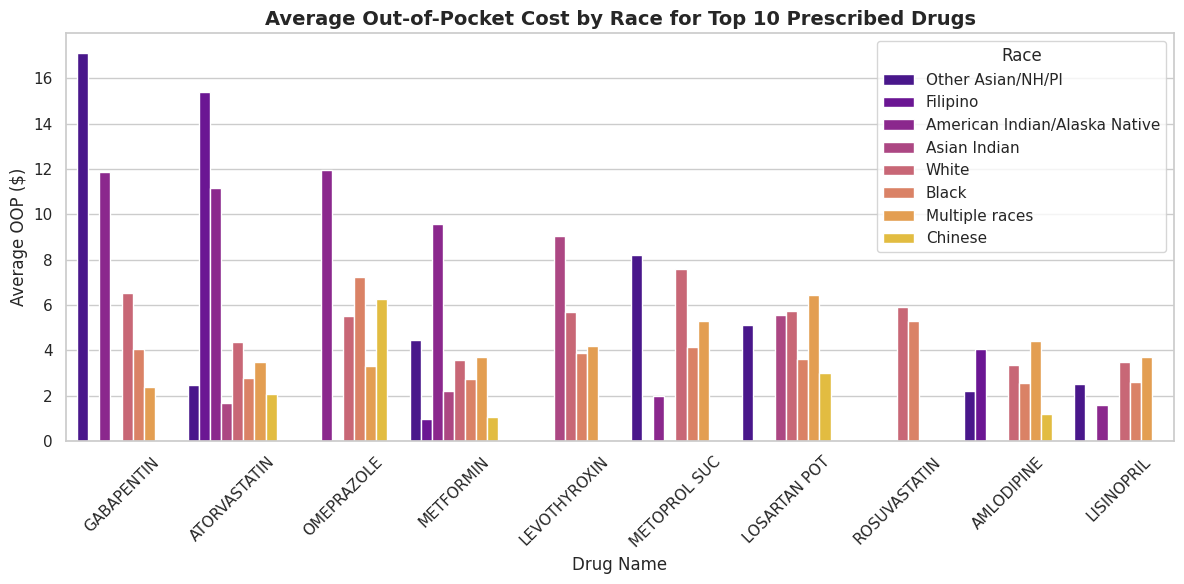

In [271]:
plt.figure(figsize=(12,6))
sns.barplot(
    x='RX_NAME',
    y='Avg_OOP',
    hue='RACE',
    data=avg_oop_per_patient,
    palette='plasma'
)

plt.title("Average Out-of-Pocket Cost by Race for Top 10 Prescribed Drugs", fontsize=14, fontweight='bold')
plt.xlabel("Drug Name")
plt.ylabel("Average OOP ($)")
plt.xticks(rotation=45)
plt.legend(title='Race')
plt.tight_layout()
plt.show()

In [190]:
merged_meps['oop_pct_income'] = (merged_meps['OOP_COST'] / (merged_meps['TOTAL_INCOME']/12)) * 100

hardship_data = merged_meps[(merged_meps['TOTAL_INCOME'] > 0) & 
                       (merged_meps['OOP_COST'] > 0) &  
                       (merged_meps['oop_pct_income'] < 50)] 

# Calculate average burden by income group
avg_burden = hardship_data.groupby('INCOME_LABEL')['oop_pct_income'].agg(['mean', 'median']).reset_index()
avg_burden = avg_burden.sort_values('mean', ascending=False)



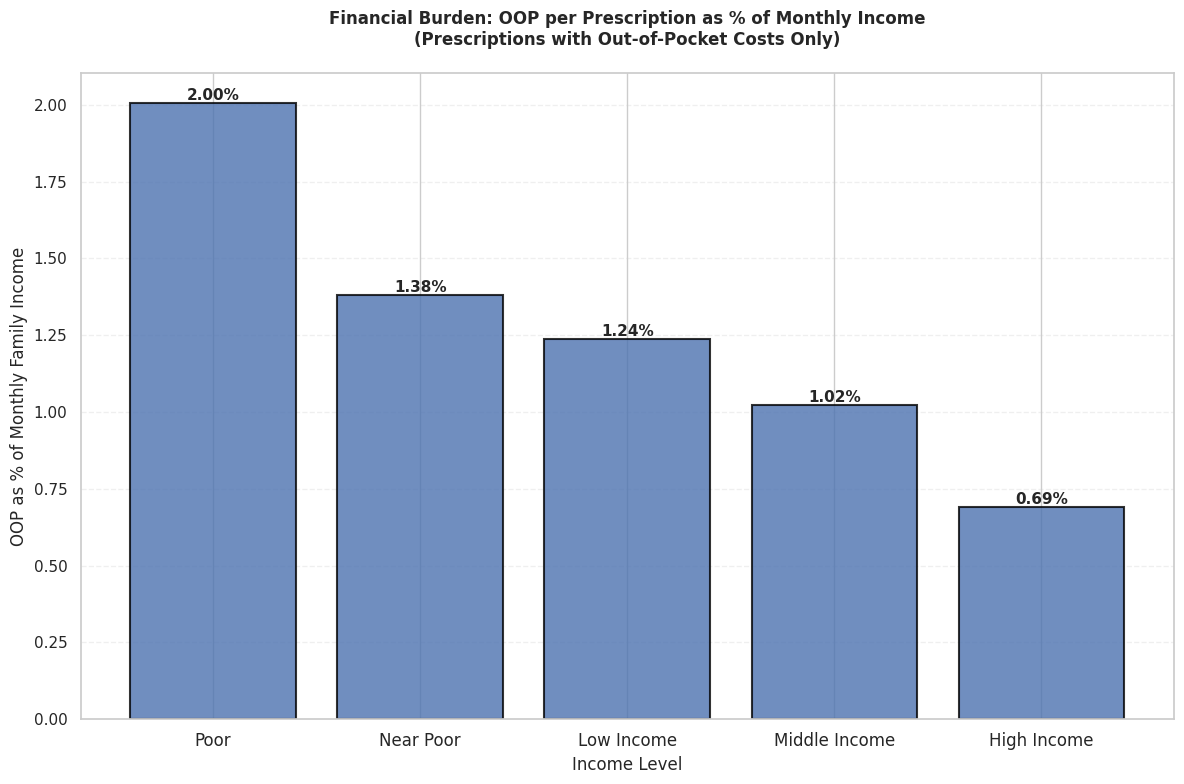

In [199]:
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(avg_burden))
bars = ax.bar(x, avg_burden['mean'], alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Income Level')
ax.set_ylabel('OOP as % of Monthly Family Income')  
ax.set_title('Financial Burden: OOP per Prescription as % of Monthly Income\n(Prescriptions with Out-of-Pocket Costs Only)', 
             fontweight='bold', pad=20)

ax.set_xticks(x)
ax.set_xticklabels(avg_burden['INCOME_LABEL'], fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')


for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', 
            ha='center', va='bottom', fontweight='bold', fontsize=11)


plt.tight_layout()
plt.show()

/tmp/ipykernel_320/1411255688.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_320/1411255688.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_320/1411255688.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_320/1411255688.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_320/1411255688.py:70: FutureWarning: The default of observed=False is deprecated and will 

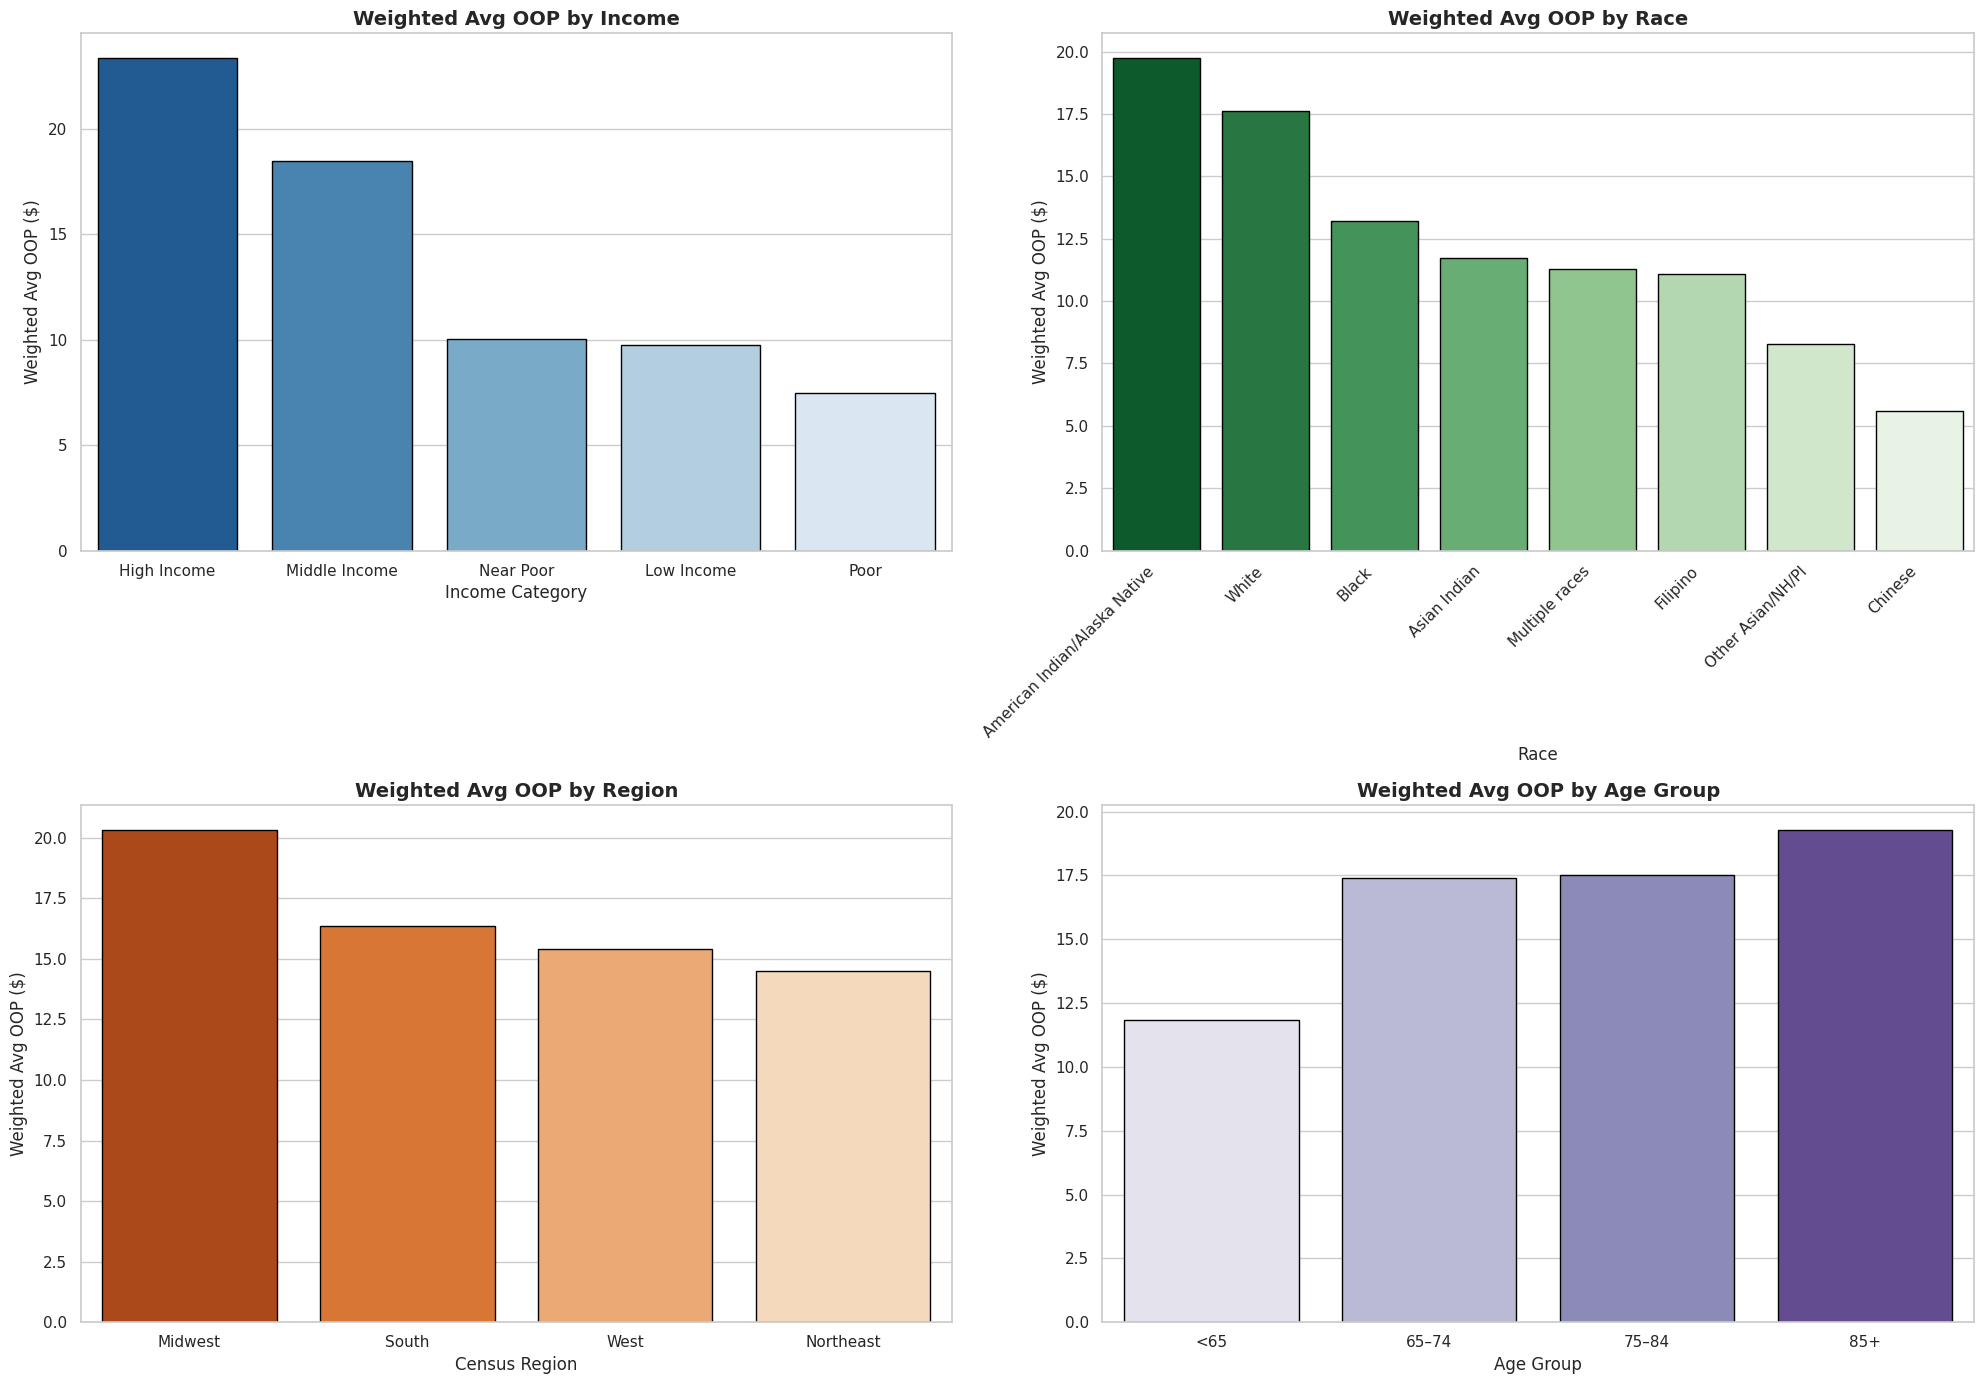

In [334]:
fig, axes = plt.subplots(2, 2, figsize=(20, 14))  

axes = axes.flatten()

weighted_avg_oop_income = (
    merged_meps.groupby('INCOME_LABEL').apply(
        lambda x: (x['OOP_COST'] * x['SURVEY_WEIGHT']).sum() / x['SURVEY_WEIGHT'].sum()
    )
).reset_index(name='Weighted_Avg_OOP')
weighted_avg_oop_income = weighted_avg_oop_income.sort_values(by='Weighted_Avg_OOP', ascending=False)

sns.barplot(
    x='INCOME_LABEL',
    y='Weighted_Avg_OOP',
    data=weighted_avg_oop_income,
    palette="Blues_r",
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title("Weighted Avg OOP by Income", fontweight='bold', fontsize=14)
axes[0].set_xlabel("Income Category")
axes[0].set_ylabel("Weighted Avg OOP ($)")


weighted_avg_oop_race = (
    merged_meps.groupby('RACE').apply(
        lambda x: (x['OOP_COST'] * x['SURVEY_WEIGHT']).sum() / x['SURVEY_WEIGHT'].sum()
    )
).reset_index(name='Weighted_Avg_OOP')
weighted_avg_oop_race = weighted_avg_oop_race.sort_values(by='Weighted_Avg_OOP', ascending=False)

sns.barplot(
    x='RACE',
    y='Weighted_Avg_OOP',
    data=weighted_avg_oop_race,
    palette="Greens_r",
    edgecolor="black",
    ax=axes[1]
)
axes[1].set_title("Weighted Avg OOP by Race", fontweight='bold',fontsize=14)
axes[1].set_xlabel("Race")
axes[1].set_ylabel("Weighted Avg OOP ($)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


weighted_avg_oop_region = (
    merged_meps.groupby('CENSUS_REGION').apply(
        lambda x: (x['OOP_COST'] * x['SURVEY_WEIGHT']).sum() / x['SURVEY_WEIGHT'].sum()
    )
).reset_index(name='Weighted_Avg_OOP')
weighted_avg_oop_region = weighted_avg_oop_region.sort_values(by='Weighted_Avg_OOP', ascending=False)

sns.barplot(
    x='CENSUS_REGION',
    y='Weighted_Avg_OOP',
    data=weighted_avg_oop_region,
    palette="Oranges_r",
    edgecolor="black",
    ax=axes[2]
)
axes[2].set_title("Weighted Avg OOP by Region", fontweight='bold', fontsize=14)
axes[2].set_xlabel("Census Region")
axes[2].set_ylabel("Weighted Avg OOP ($)")

weighted_avg_oop_age = (
    merged_meps.groupby('AGE_GROUP').apply(
        lambda x: (x['OOP_COST'] * x['SURVEY_WEIGHT']).sum() / x['SURVEY_WEIGHT'].sum()
    )
).reset_index(name='Weighted_Avg_OOP')
weighted_avg_oop_age = weighted_avg_oop_age.sort_values(by='Weighted_Avg_OOP', ascending=False)

sns.barplot(
    x='AGE_GROUP',
    y='Weighted_Avg_OOP',
    data=weighted_avg_oop_age,
    palette="Purples",
    edgecolor="black",
    ax=axes[3]
)
axes[3].set_title("Weighted Avg OOP by Age Group", fontweight='bold', fontsize=14)
axes[3].set_xlabel("Age Group")
axes[3].set_ylabel("Weighted Avg OOP ($)")

plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=af057222-3fdc-4af3-880a-2119daf62f90' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>